In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.linear_model
import sklearn.neighbors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import warnings
warnings.filterwarnings("ignore")

import sklearn
from collections import Counter 
import imblearn
import mrmr
import matplotlib.pyplot as plt  
import time

import mlxtend.feature_selection

{'Healthy': 112, 'AD_MCI': 37, 'PD_MCI_LBD': 27, 'PD': 26}
{'Healthy': 20, 'AD_MCI': 6, 'PD_MCI_LBD': 5, 'PD': 5}
Randstate: 432254009

Percent Healthy in dev, test: [0.5544554455445545, 0.5555555555555556] 
Standard deviation of these values: 0.0005500550055005382 


Percent AD_MCI in dev, test: [0.18316831683168316, 0.16666666666666666] 
Standard deviation of these values: 0.008250825082508254 


Percent PD in dev, test: [0.12871287128712872, 0.1388888888888889] 
Standard deviation of these values: 0.0050880088008800894 


Percent PD_MCI_LBD in dev, test: [0.13366336633663367, 0.1388888888888889] 
Standard deviation of these values: 0.002612761276127612 



In [104]:
data_full = pd.read_csv('full_data_short.csv')

In [3]:
def handle_scale_and_nan(frame,nandecision='drop',scale='MinMax'):
    features = list(frame.select_dtypes(include='float64'))
    cat = list(frame.select_dtypes(include='object'))

    if scale == 'MinMax':
        scaler = sklearn.preprocessing.MinMaxScaler().fit(frame[features])
    elif scale == 'Standard':
        scaler = sklearn.preprocessing.StandardScaler().fit(frame[features])
        
    df_cont = pd.DataFrame(data=scaler.transform(frame[features]), columns=features)
    df_cat = pd.DataFrame(data=frame[cat], columns=cat)
    
    frame = pd.concat([df_cat,df_cont],axis=1)
    
    if nandecision == 'mean':
            for feature in features:
                frame[feature].fillna((frame[feature].mean()), inplace=True)
    elif nandecision == 'drop':
            frame = frame.dropna(axis=1)
        
    return frame

In [4]:
data_full = handle_scale_and_nan(data_full,nandecision='drop',scale='MinMax')

In [74]:
def split_cats_by_tolerance(frame,tolerance,silent=False,randomstate=98281,split=0.15,step=1,categories=['Healthy','AD_MCI','PD','PD_MCI_LBD']):
    tolerable_list =[]
    if randomstate == None:
        randomstate=np.random.randint(0,2**31)
    elif type(randomstate) == int:
        pass
    while sum(tolerable_list) != 4:
        df_dev, df_test = sklearn.model_selection.train_test_split(frame,test_size=split,random_state=randomstate)
        
        dev_dict = dict(df_dev['group'].value_counts())
        test_dict = dict(df_test['group'].value_counts())
        
        tolerable_list = []
        stats_dict ={}
        for i in range(0,len(categories)):
            try:
                percents = [(dev_dict[categories[i]]/len(df_dev)),(test_dict[categories[i]]/len(df_test))]
            except:
                break
            standdev = np.std(percents)
            if standdev <= tolerance:
                tolerable_list.append(1)
                stats_dict[str(categories[i])] = [[*percents],standdev]
            else:
                tolerable_list.append(0)
                
        randomstate += step

    if sum(tolerable_list) == 4:
        if silent == False:
            print(dev_dict)
            print(test_dict)
            print('Randstate:',randomstate-1)
            for i in range(0,len(categories)):            
                print('\nPercent',categories[i],'in dev, test:',stats_dict[categories[i]][0],
                      '\nStandard deviation of these values:',stats_dict[categories[i]][1],'\n')
        elif silent == True:
            pass
            
    return df_dev, df_test


In [107]:
data_dev, data_test = split_cats_by_tolerance(data_full,0.01,randomstate=98281)

{'Healthy': 132, 'AD_MCI': 43, 'PD_MCI_LBD': 32, 'PD': 31}
{'Healthy': 24, 'AD_MCI': 8, 'PD_MCI_LBD': 5, 'PD': 5}
Randstate: 98281

Percent Healthy in dev, test: [0.5546218487394958, 0.5714285714285714] 
Standard deviation of these values: 0.008403361344537785 


Percent AD_MCI in dev, test: [0.18067226890756302, 0.19047619047619047] 
Standard deviation of these values: 0.004901960784313722 


Percent PD in dev, test: [0.13025210084033614, 0.11904761904761904] 
Standard deviation of these values: 0.005602240896358551 


Percent PD_MCI_LBD in dev, test: [0.13445378151260504, 0.11904761904761904] 
Standard deviation of these values: 0.007703081232492998 



In [109]:
data_dev.to_csv('dev.csv')

In [111]:
data_test.to_csv('test.csv')

In [87]:
def over_under(df_train,df_val,cat_in_excess='Healthy',target='group',randomstate=np.random.randint(0,4294967295), silent=False):
    """
    Takes dataframe(s) with only the target value and float64 features
    This function is to balance the samples in an imbalanced training dataset that has one category in excess, with additional categories more near each other
    The categories below the category in excess will be oversampled to equality, then the category in excess will be undersampled to equality
    ---Parameters---
    df_train: the training dataframe
    df_val: the validation dataframe
    cat_in_excess: the category which is present in excess, far above the other categories
    target: target column in the dataframe
    randomstate: if chosen, this will the random state for the sampling. Default: None, numpy random integer method between 0 and 4294967295, the range of the sampling module used
    randomstate_sampler: the number of loops to run to compare random states starting from 
    """

        
    # Drop the excessive category and oversample minority to the intermediate category
    df_train_no_excess = df_train[df_train.group != cat_in_excess]
    over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=randomstate)
    X_train = df_train_no_excess.drop(columns=target)
    y_train = df_train_no_excess[target]
    X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
    df_train_over = pd.concat([y_train_over,X_train_over],axis=1)

    # Re-introduce the excessive category and undersample the majority to the minority
    df_train_excess = pd.concat([df_train_over,df_train[df_train[target] == cat_in_excess]])
    under_sampler = imblearn.under_sampling.RandomUnderSampler(random_state=randomstate)
    X_train = df_train_excess.drop(columns=target)
    y_train = df_train_excess[target]
    X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
    df_train_eq = pd.concat([y_train_under,X_train_under],axis=1)
    
    if silent == False:
        print(randomstate)
    elif silent == True:
        pass
    
    return df_train_eq

        


In [13]:
import sklearn.feature_selection

In [28]:
data_train, data_val, randomstate = split_cats_by_tolerance(data_dev,tolerance=0.01)
data_traineq, randomstate = over_under(data_train,data_val)

{'Healthy': 112, 'AD_MCI': 37, 'PD_MCI_LBD': 27, 'PD': 26}
{'Healthy': 20, 'AD_MCI': 6, 'PD': 5, 'PD_MCI_LBD': 5}
Randstate: 614535837

Percent Healthy in dev, test: [0.5544554455445545, 0.5555555555555556] 
Standard deviation of these values: 0.0005500550055005382 


Percent AD_MCI in dev, test: [0.18316831683168316, 0.16666666666666666] 
Standard deviation of these values: 0.008250825082508254 


Percent PD in dev, test: [0.12871287128712872, 0.1388888888888889] 
Standard deviation of these values: 0.0050880088008800894 


Percent PD_MCI_LBD in dev, test: [0.13366336633663367, 0.1388888888888889] 
Standard deviation of these values: 0.002612761276127612 

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [29]:
X_traineq = data_traineq.drop(columns='group')
y_traineq = data_traineq['group']

In [46]:
model = sklearn.linear_model.RidgeClassifier()
sfs_forward = mlxtend.feature_selection.SequentialFeatureSelector(model,k_features=5,forward=True,cv=None,verbose=1,n_jobs=-1)
sfs_forward = sfs_forward.fit(X_traineq,y_traineq)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1138 out of 1138 | elapsed:    0.4s finished
Features: 1/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1137 out of 1137 | elapsed:    0.4s finished
Features: 2/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1136 out of 1136 | elapsed:    0.5s finished
Features: 3/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1135 out of 1135 | elapsed:    0.5s finished
Features: 4/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: 

In [49]:
sfs_forward_feature_list = list(sfs_forward.k_feature_names_)

In [ ]:
X_train

In [41]:
np.shape(sfs_forward)

(148, 10)

In [ ]:
feature_performances = mrmr_shorthand(X_traineq,y_traineq,X_val,y_val,list(range(min_features,max_features+1,step_features)),model)

In [52]:
def sfs_shorthand(X_train, y_train,X_val,y_val,K,model):
    feature_performance = []
    for k in K:
        sfs_forward = mlxtend.feature_selection.SequentialFeatureSelector(model,k_features=5,forward=True,cv=None,verbose=1,n_jobs=-1)
        sfs_forward = sfs_forward.fit(X_traineq,y_traineq)
        reduced_features = list(sfs_forward.k_feature_names_)
        X_train_reduced = X_train[reduced_features]
        X_val_reduced = X_val[reduced_features]
        model.fit(X_train_reduced,y_train)
        feature_performance.append([k,score(y_val,model.predict(X_val_reduced)),reduced_features])
    return feature_performance

In [54]:
X_val = data_val.drop(columns='group')
y_val = data_val['group']

In [55]:
feature_performances = sfs_shorthand(X_traineq,y_traineq,X_val,y_val,[3,4],model=sklearn.linear_model.RidgeClassifier())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1138 out of 1138 | elapsed:    2.2s finished
Features: 1/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1137 out of 1137 | elapsed:    0.5s finished
Features: 2/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1136 out of 1136 | elapsed:    0.5s finished
Features: 3/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1135 out of 1135 | elapsed:    0.4s finished
Features: 4/5[Parallel(n_jobs=-1)]: Using backend L

NameError: name 'score' is not defined

In [ ]:
sklearn.metrics.balanced_accuracy_score(y_val,model.predict(X_val))

In [91]:
def mrmr_shorthand(X_train, y_train,X_val,y_val,K,model,score):
    feature_performance = []

    for k in K:
        reduced_features = mrmr.mrmr_classif(X_train,y_train,K=k)
        X_train_reduced = X_train[reduced_features]
        X_val_reduced = X_val[reduced_features]
        model.fit(X_train_reduced,y_train)
        feature_performance.append([k,score(y_val,model.predict(X_val_reduced)),reduced_features])
    return feature_performance

In [94]:
def mrmr_feature_selection(data_dev, split, 
    min_features, max_features, step_features, folds,
    tolerance=0.01,featureselector=mrmr.mrmr_classif,model=sklearn.linear_model.RidgeClassifier(),score=sklearn.metrics.balanced_accuracy_score):

    """
    data_dev: development data in a pandas dataframe
    split: split proportion of training and val data each time a fold is executed
    min_features: minimum number of features to return
    max_features: maximum number of features to return
    step_features: step between evaluation of features
    folds: number of repeat evaluations of one feature space size. The training and validation data will be resampled from the dev data each time. It is important that test data is not fed to this function. 
    tolerance: (Default=0.01) acceptable level of standard deviation between categories among the training and validation data. Percent categories are calculated first, then their stdev is calculated and compared to the stated tolerance


    """


    t0 = time.time()
    folded_performances = []
    i=0
    while i < folds:
        # Split dev data
        data_train, data_val = split_cats_by_tolerance(data_dev,tolerance,silent=True,split=split)

        # Equalize the training data
        train_eq = over_under(data_train,data_val,silent=True)

        # Separate features from categories
        X_traineq = train_eq.drop(columns='group')
        y_traineq = train_eq['group']
        X_val = data_val.drop(columns='group')
        y_val = data_val['group']
        feature_performances = mrmr_shorthand(X_traineq,y_traineq,X_val,y_val,list(range(min_features,max_features+1,step_features)),model,score)
        folded_performances.append(feature_performances)
        i += 1

    folded_performances = pd.DataFrame(data=folded_performances)

    performance_mean = []
    for j in range(0,len(folded_performances.columns)):
        performance_values = []
        for i in range(0,len(folded_performances)):
            folded_list = folded_performances[j].iloc[i]
            featnum = folded_list[0]
            scores = folded_list[1]
            feats = folded_list[2]
            performance_values.append([featnum,scores,feats])

        scores = []
        for i in range(0,len(performance_values)):
            scores.append(performance_values[i][1])
        mean_score = np.mean(scores)

        features = []
        for i in range(0,len(performance_values)):
            features.append(performance_values[i][2])
        #features = list(np.unique(features))
        
        std = np.std(scores)
        ci68 = scipy.stats.norm.interval(0.68, loc=mean_score, scale=std)
        yerr = float(np.diff(ci68))/2
        
            
        performance_mean.append([featnum,scores,mean_score,std,ci68,yerr,features])
        number, scores, mean_score, std, ci68, yerr, features = zip(*performance_mean)

    performance_mean = pd.DataFrame(data=performance_mean,columns=['feature_num','ind_scores','avg_score','stdev','ci68','yerr','features'])
    plt.scatter(x=performance_mean['feature_num'],y=performance_mean['avg_score'],marker=".", s=1)
    plt.errorbar(x=performance_mean['feature_num'],y=performance_mean['avg_score'], c='black',elinewidth=1, yerr=performance_mean['yerr'], fmt="o")
    plt.show()
    t1 = time.time()
    total_time = t1-t0
    print('Time elapsed:',total_time)
    return performance_mean

100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  8.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


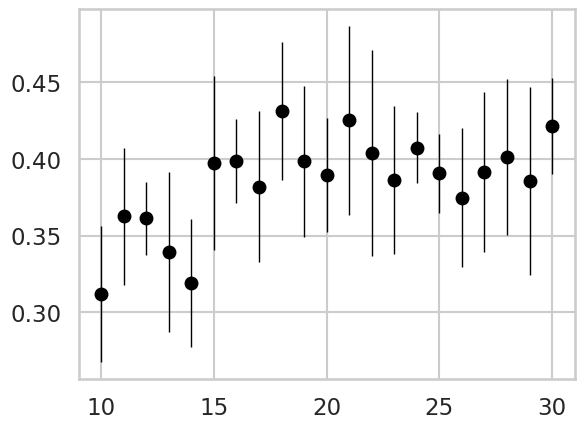

Time elapsed: 572.8996894359589


In [97]:
rforest_performance = mrmr_feature_selection(data_dev,split=0.15,min_features=10,max_features=30,step_features=1,folds=10,model=sklearn.ensemble.RandomForestClassifier())

In [99]:
rforest_performance.to_csv('rforest_10_30_features.csv')

In [ ]:
mrmr.mrmr_classif()

100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.17it/s]


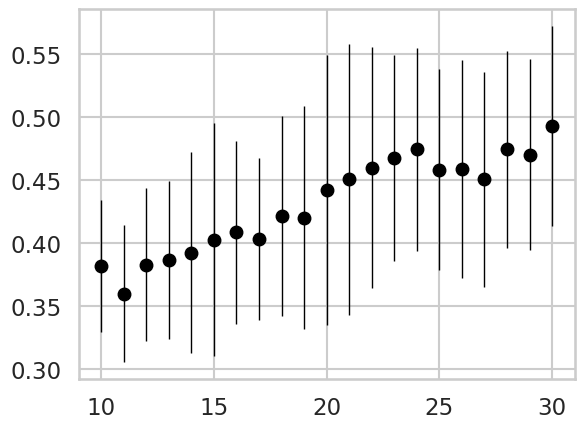

Time elapsed: 526.2903747558594


In [64]:
ridge_performance = mrmr_feature_selection(data_dev,split=0.15,min_features=10,max_features=30,step_features=1,folds=10,model=sklearn.linear_model.RidgeClassifier())

In [100]:
ridge_performance.to_csv('ridge_10_30_features.csv')

100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.32it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.76it/s]


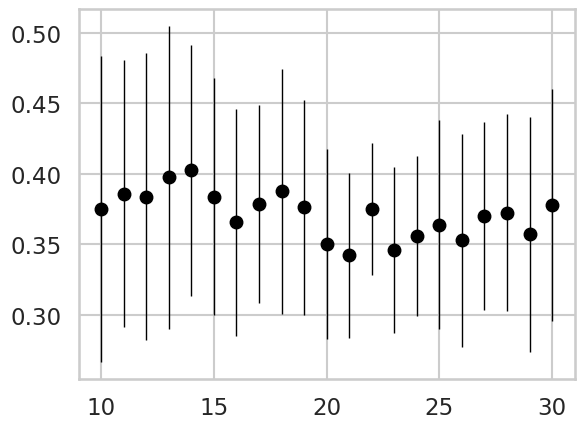

Time elapsed: 522.288400888443


In [67]:
dectree_performance = mrmr_feature_selection(data_dev,split=0.15,min_features=10,max_features=30,step_features=1,folds=10,model=sklearn.tree.DecisionTreeClassifier())

In [101]:
dectree_performance.to_csv('dectree_10_30_features.csv')

In [72]:
import sklearn.naive_bayes

100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  8.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.11it/s]


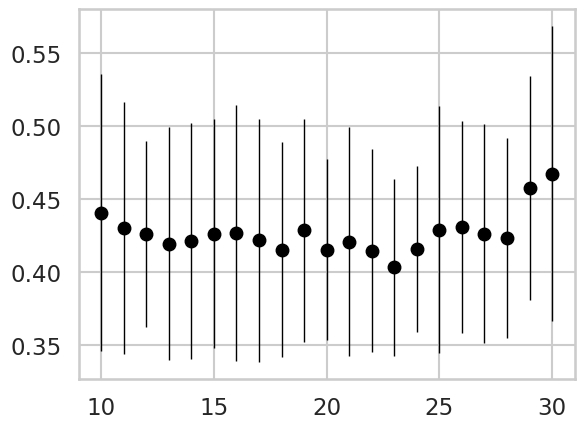

Time elapsed: 564.4640038013458


In [73]:
nbayes_performance = mrmr_feature_selection(data_dev,split=0.15,min_features=10,max_features=30,step_features=1,folds=10,model=sklearn.naive_bayes.GaussianNB())

In [102]:
nbayes_performance.to_csv('nbayes_10_30_features.csv')

AttributeError: 'tuple' object has no attribute 'drop'